In [12]:
import cv2
import numpy as np
import os 
def crop_and_resize(image, size=80):
    h, w = image.shape[:2]
    min_dim = min(h, w)
    center_h = h // 2
    center_w = w // 2
    half_size = min_dim // 2
    left = center_w - half_size
    right = center_w + half_size
    top = center_h - half_size
    bottom = center_h + half_size
    cropped_image = image[top:bottom, left:right]
    
    resized_image = cv2.resize(cropped_image, (size, size))
    return resized_image
from PIL import Image
data_path = "Data\\images_original"
genres = np.array(os.listdir(data_path))
X = []
y = []
for genre_idx, genre in enumerate(genres[:8]):
    genre_path = os.path.join(data_path, genre)
    audio_filenames = os.listdir(genre_path)
    audio_paths = [os.path.join(genre_path, audio_filename) for audio_filename in audio_filenames]
    for i in audio_paths:
        img=np.array(Image.open(i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img=crop_and_resize(img)
        img=(img-np.mean(img,axis=0))/np.std(img,axis=0)
        X.append(img)
        y.append(genre_idx)
x=np.array(X)
y=np.array(y)


In [13]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
d=OneHotEncoder()
y_train=d.fit_transform(y_train.reshape(-1,1)).toarray()
y_val=d.fit_transform(y_val.reshape(-1,1)).toarray()
X_train=np.expand_dims(X_train,axis=-1)
X_val=np.expand_dims(X_val,axis=-1)


In [14]:

from sklearn.model_selection import train_test_split
import tensorflow as tf


batch_size = 128


train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)



In [198]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

input_shape = (80, 80, 1)
num_classes = 8

# First parallel branch
inputs1 = tf.keras.Input(shape=input_shape)
conv1_1 = Conv2D(3, (8, 8), padding='same')(inputs1)
leaky1_1 = LeakyReLU(alpha=0.3)(conv1_1)
pool1_1 = MaxPooling2D((4, 4))(leaky1_1)
flat1_1 = Flatten()(pool1_1)
print(flat1_1.shape)

# Second parallel branch
conv2_1 = Conv2D(4, (4, 4), padding='same')(inputs1)
leaky2_1 = LeakyReLU(alpha=0.3)(conv2_1)
pool2_1 = MaxPooling2D((2, 2))(leaky2_1)
flat2_1 = Flatten()(pool2_1)
print(flat2_1.shape)

# Merging branch
merged = Concatenate()([flat1_1, flat2_1])
dense1 = Dense(32, activation='relu')(merged)
print(dense1.shape)
output = Dense(num_classes, activation='softmax')(dense1)

# Compile model
model = Model(inputs=inputs1, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


(None, 1200)
(None, 6400)
(None, 32)
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 80, 80, 3)    195         input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 80, 80, 4)    68          input_27[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_50 (LeakyReLU)      (None, 80, 80, 3)    0           conv2d_76[0][0]                  
______________________________________________________

Epoch 1/50
5/5 [==============================] - 1s 41ms/step - loss: 2.4003 - accuracy: 0.1315 - val_loss: 2.2787 - val_accuracy: 0.1187
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 2.2101 - accuracy: 0.1534 - val_loss: 2.0689 - val_accuracy: 0.0812
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 2.0464 - accuracy: 0.1800 - val_loss: 2.0636 - val_accuracy: 0.1000
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 2.0047 - accuracy: 0.1581 - val_loss: 2.0081 - val_accuracy: 0.1750
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 1.9676 - accuracy: 0.2222 - val_loss: 1.9935 - val_accuracy: 0.1813
Epoch 6/50
5/5 [==============================] - 0s 15ms/step - loss: 1.9362 - accuracy: 0.2113 - val_loss: 1.9872 - val_accuracy: 0.1312
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 1.9084 - accuracy: 0.2316 - val_loss: 1.9466 - val_accuracy: 0.2250
Epoch 8/50
5/5 [===========

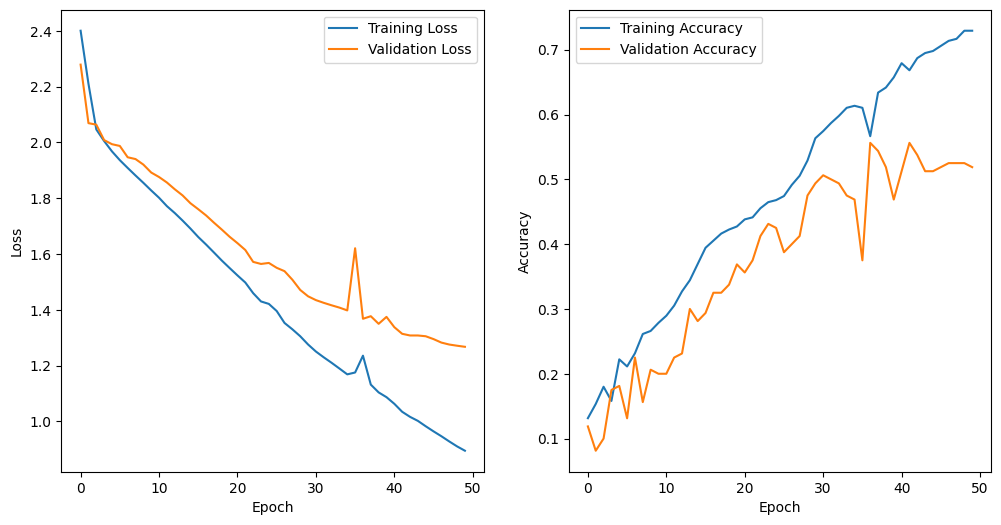

In [199]:
epochs = 50

history = model.fit(train_dataset, epochs=epochs, batch_size=128,validation_data=val_dataset)

# Plot loss and accuracy over epochs
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


In [10]:
def reduce_dimension(x, y):
    return tf.squeeze(x, axis=-1), y

train_dataset_squeeze = train_dataset.map(reduce_dimension)
val_dataset_squeeze=val_dataset.map(reduce_dimension)

In [214]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN-RNN model
model = tf.keras.Sequential([
    # Convolutional layers
    layers.Conv2D(8, (4,4), activation='relu', input_shape=(80,80,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(6, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Recurrent layers
    layers.Reshape((108, -1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(32),
    # Dense layers
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 77, 77, 8)         136       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 36, 36, 6)         438       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 18, 18, 6)         0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 108, 18)           0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 108, 128)          75264     
_________________________________________________________________
lstm_44 (LSTM)               (None, 32)              

Epoch 1/50
5/5 [==============================] - 4s 361ms/step - loss: 2.0808 - accuracy: 0.1236 - val_loss: 2.0888 - val_accuracy: 0.0812
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 2.0771 - accuracy: 0.1362 - val_loss: 2.0938 - val_accuracy: 0.0812
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 2.0748 - accuracy: 0.1362 - val_loss: 2.0917 - val_accuracy: 0.0812
Epoch 4/50
5/5 [==============================] - 0s 30ms/step - loss: 2.0687 - accuracy: 0.1628 - val_loss: 2.0815 - val_accuracy: 0.1375
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 2.0488 - accuracy: 0.2019 - val_loss: 2.0551 - val_accuracy: 0.1500
Epoch 6/50
5/5 [==============================] - 0s 33ms/step - loss: 2.0050 - accuracy: 0.2316 - val_loss: 2.0073 - val_accuracy: 0.1500
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 1.9359 - accuracy: 0.2551 - val_loss: 1.9154 - val_accuracy: 0.1625
Epoch 8/50
5/5 [==========

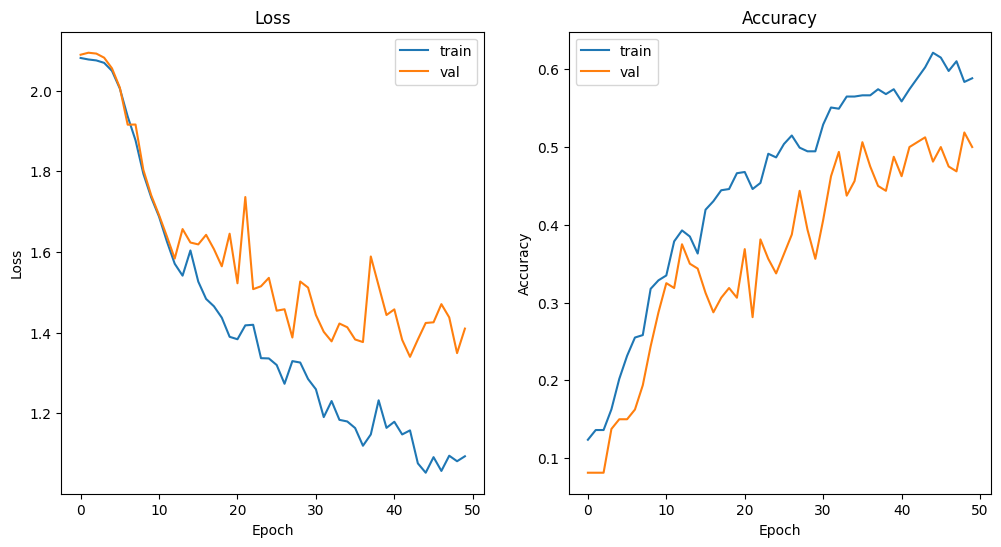

In [215]:


# Train the model
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

# Plot the loss function and accuracy on train and validation sets
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12, 6))

axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.show()


In [16]:
from tensorflow import keras
# Data augmentation
train_dataset_augment = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_dataset_augment = train_dataset_augment.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))

train_dataset_augment

<MapDataset shapes: ((None, 80, 80, 1), (None, 8)), types: (tf.float64, tf.float64)>

In [ ]:

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(128))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(train_dataset_augment,
                    epochs=100,
                    validation_data=val_dataset)




In [64]:
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_addons as tfa

# Add more data augmentation techniques
train_dataset_augment = train_dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
train_dataset_augment = train_dataset_augment.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))


<MapDataset shapes: ((None, 80, 80, 1), (None, 8)), types: (tf.float64, tf.float64)>

In [170]:

# Define the model
# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))  # Reduce dropout rate
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))  # Reduce dropout rate
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(256))  # Increase LSTM units
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))  # Reduce L2 regularization
model.add(layers.Dropout(0.15))  # Reduce dropout rate
model.add(layers.Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizers.Adam(lr=0.001),  # Increase learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history = model.fit(train_dataset_augment,
                    epochs=200,  # Increase training epochs
                    validation_data=val_dataset,
                    callbacks=[reduce_lr, early_stopping])

 # Add callbacks

Epoch 1/200
5/5 [==============================] - 3s 185ms/step - loss: 2.1746 - accuracy: 0.1393 - val_loss: 2.1659 - val_accuracy: 0.1375
Epoch 2/200
5/5 [==============================] - 0s 95ms/step - loss: 2.1583 - accuracy: 0.1268 - val_loss: 2.1593 - val_accuracy: 0.0812
Epoch 3/200
5/5 [==============================] - 0s 94ms/step - loss: 2.1508 - accuracy: 0.1377 - val_loss: 2.1597 - val_accuracy: 0.0812
Epoch 4/200
5/5 [==============================] - 0s 95ms/step - loss: 2.1327 - accuracy: 0.1377 - val_loss: 2.1455 - val_accuracy: 0.0875
Epoch 5/200
5/5 [==============================] - 0s 94ms/step - loss: 2.0884 - accuracy: 0.2113 - val_loss: 2.0831 - val_accuracy: 0.2000
Epoch 6/200
5/5 [==============================] - 0s 94ms/step - loss: 2.0036 - accuracy: 0.2817 - val_loss: 2.0358 - val_accuracy: 0.1375
Epoch 7/200
5/5 [==============================] - 0s 94ms/step - loss: 1.9163 - accuracy: 0.2926 - val_loss: 2.1671 - val_accuracy: 0.2438
Epoch 8/200
5/5 [==

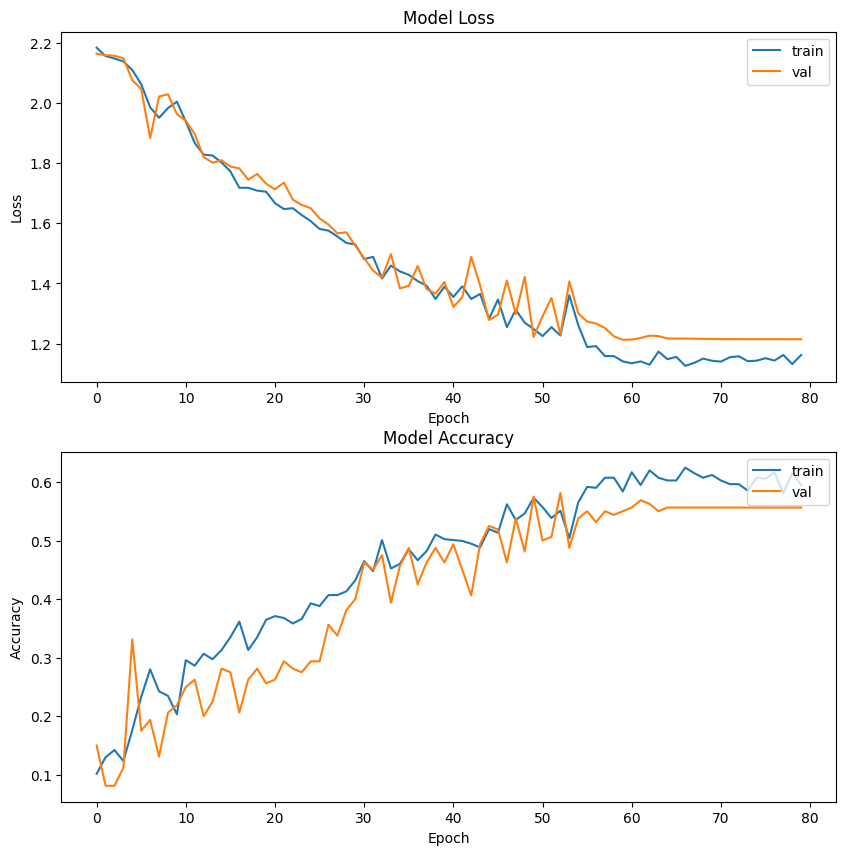

In [168]:

import matplotlib.pyplot as plt
# Plot the training and validation loss and accuracy
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='upper right')

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='upper right')

plt.show()

